## Init

In [15]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [16]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


## Data Preparation

In [25]:
from scripts.matlab.load_time_course_data import load_timecourse_data
from scripts.matlab.load_target_data import load_target_data
from models.Utils import last_time_point_method, dynamic_features_method
import pandas as pd 
import pickle

file_path = f'{config["DATA_PATH"]}/matlab_output/ground_truth_data.csv'
simulation_data = pd.read_csv(file_path, index_col=0)
feature_data_file_path = f'notebooks/tests/shared_dir/src/feature_data.pkl'
with open(feature_data_file_path, 'rb') as f:
    feature_data = pickle.load(f)
ground_time_course_data = load_timecourse_data(simulation_data, index_option='cell_id')
target_data = load_target_data(simulation_data, 'pERK', index_option='cell_id')

all_species = list(ground_time_course_data.columns)
# remove 'pERK' from all_species since it is the target variable
all_species.remove('pERK')

last_time_data = last_time_point_method(ground_time_course_data, all_species)
dynamic_data = dynamic_features_method(ground_time_course_data, all_species, n_cores=8)

combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)

feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']
o_random_seed = 42
target_name = 'pERK'

output_file_path = f'{config["DATA_PATH"]}/matlab_output/exp22_sampled_eval_results.pkl' 


In [22]:
import pandas as pd
import numpy as np

def sample_feature_datasets(feature_data_list, min_samples=50, max_samples=250, step=50, random_seed=42):
    """
    Subsamples a list of feature datasets to common indices.

    Parameters:
    - feature_data_list (List[pd.DataFrame]): List of dataframes to be subsampled.
    - min_samples (int): Minimum number of samples.
    - max_samples (int): Maximum number of samples.
    - step (int): Step size for number of samples.
    - random_seed (int): Seed for reproducible sampling.

    Returns:
    - dict[int, List[pd.DataFrame]]: Dictionary with sample size as key and list of sampled DataFrames as value.
    """
    if not feature_data_list:
        raise ValueError("Input feature_data_list is empty.")
    
    # Find common indices across all dataframes
    common_index = set(feature_data_list[0].index)
    for df in feature_data_list[1:]:
        common_index &= set(df.index)
    
    common_index = sorted(common_index)
    rng = np.random.default_rng(random_seed)

    sampled_datasets = {}

    for n_samples in range(min_samples, max_samples + 1, step):
        if n_samples > len(common_index):
            raise ValueError(f"Requested {n_samples} samples, but only {len(common_index)} common indices available.")
        
        sampled_idx = rng.choice(common_index, size=n_samples, replace=False)
        sampled_batch = [df.loc[sampled_idx].copy() for df in feature_data_list]
        sampled_datasets[n_samples] = sampled_batch

    return sampled_datasets


## Machine Learning 

In [ ]:
import pandas as pd
from ml.Workflow import batch_eval_standard

# Sample datasets
sampled_dict = sample_feature_datasets(
    feature_data_list,
    min_samples=50,
    max_samples=250,
    step=50,
    random_seed=o_random_seed
)

all_results = []

for sample_size, sampled_data_list in sampled_dict.items():
    print(f"Running evaluation for sample size = {sample_size}...")

    metric_df = batch_eval_standard(
        feature_data_list=sampled_data_list,
        feature_data_names=feature_data_names,
        target_data=target_data,
        target_name=target_name,
        num_repeats=10,
        test_size=0.2,
        o_random_seed=o_random_seed,
        n_jobs=-1
    )

    metric_df["sample_size"] = sample_size
    all_results.append(metric_df)

    print(f"Completed: sample size = {sample_size}, shape = {metric_df.shape}")

final_df = pd.concat(all_results, ignore_index=True)
with open(output_file_path, 'wb') as f:
    pickle.dump(final_df, f)
print(f"Results saved to {output_file_path}")

## Visualisation

In [26]:
# load the results
with open(output_file_path, 'rb') as f:
    results_df = pickle.load(f)
    

In [27]:
results_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,sample_size
0,Linear Regression,feature_data,2.532387e+07,-3.687220,0.500791,1.403849e-01,50
1,Linear Regression,feature_data,3.346462e+07,-31.501708,0.433567,2.106499e-01,50
2,Linear Regression,feature_data,9.027096e+07,-1.378814,0.669202,3.432295e-02,50
3,Linear Regression,feature_data,4.641102e+07,-2276.705432,-0.180235,6.182959e-01,50
4,Linear Regression,feature_data,5.093309e+07,-10.201824,0.802685,5.186829e-03,50
...,...,...,...,...,...,...,...
1245,Neural Network,combined_dyn_data,1.660351e+07,-0.307401,0.655029,2.454739e-07,250
1246,Neural Network,combined_dyn_data,2.728034e+07,0.666465,0.818935,3.675175e-13,250
1247,Neural Network,combined_dyn_data,1.659668e+07,-0.850603,0.844940,1.214392e-14,250
1248,Neural Network,combined_dyn_data,2.646765e+07,0.689097,0.856018,2.337901e-15,250


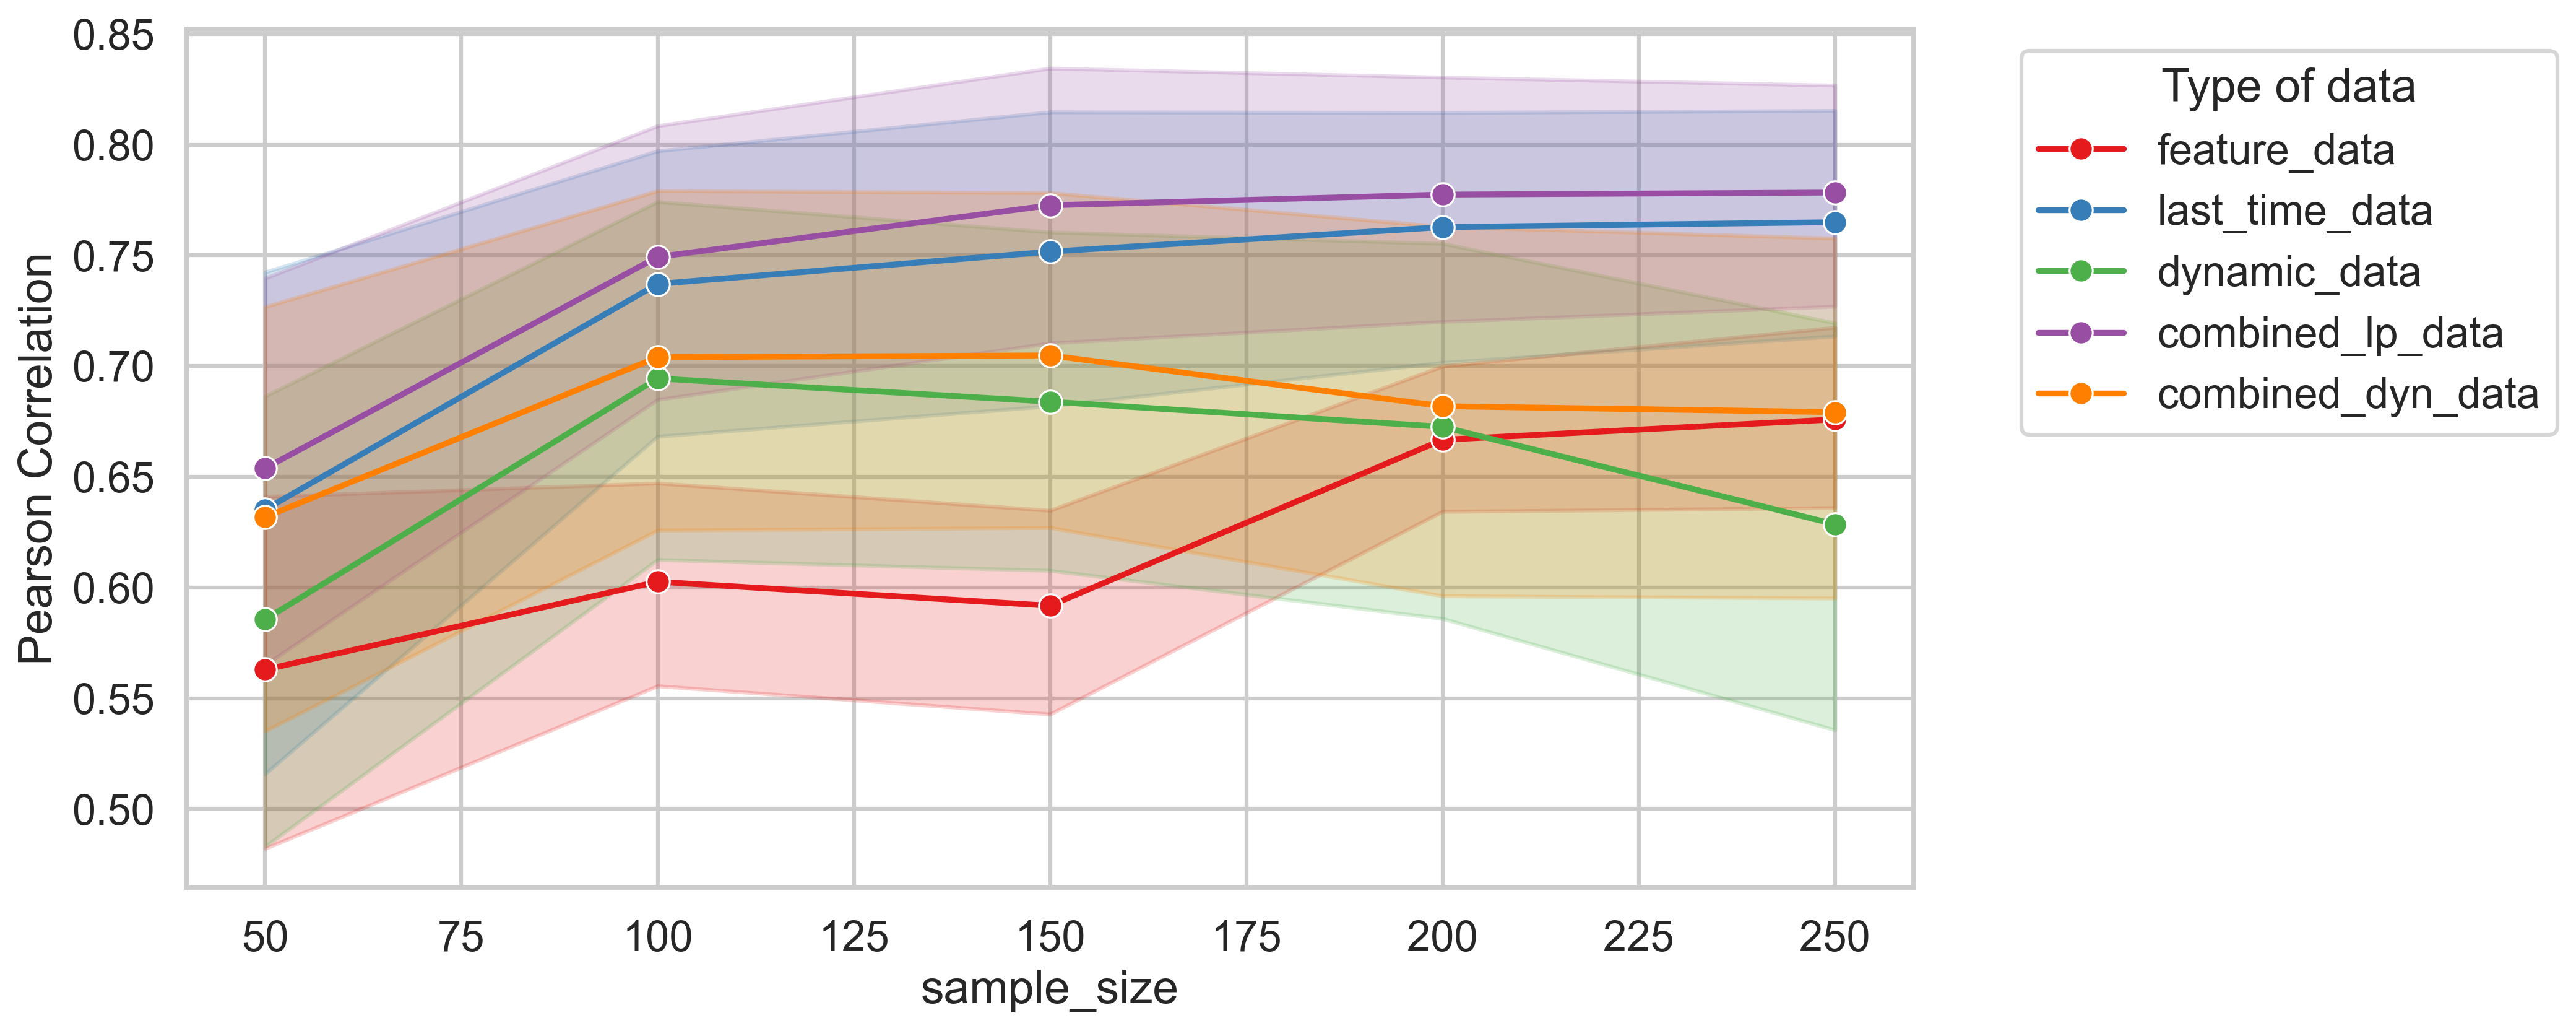

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Plot setup
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

sns.lineplot(data=results_df, x='sample_size', y='Pearson Correlation', hue='Feature Data', palette='Set1', marker='o')
# 90 degree rotation of the x-axis labels
# legend to the right
plt.legend(title='Type of data', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

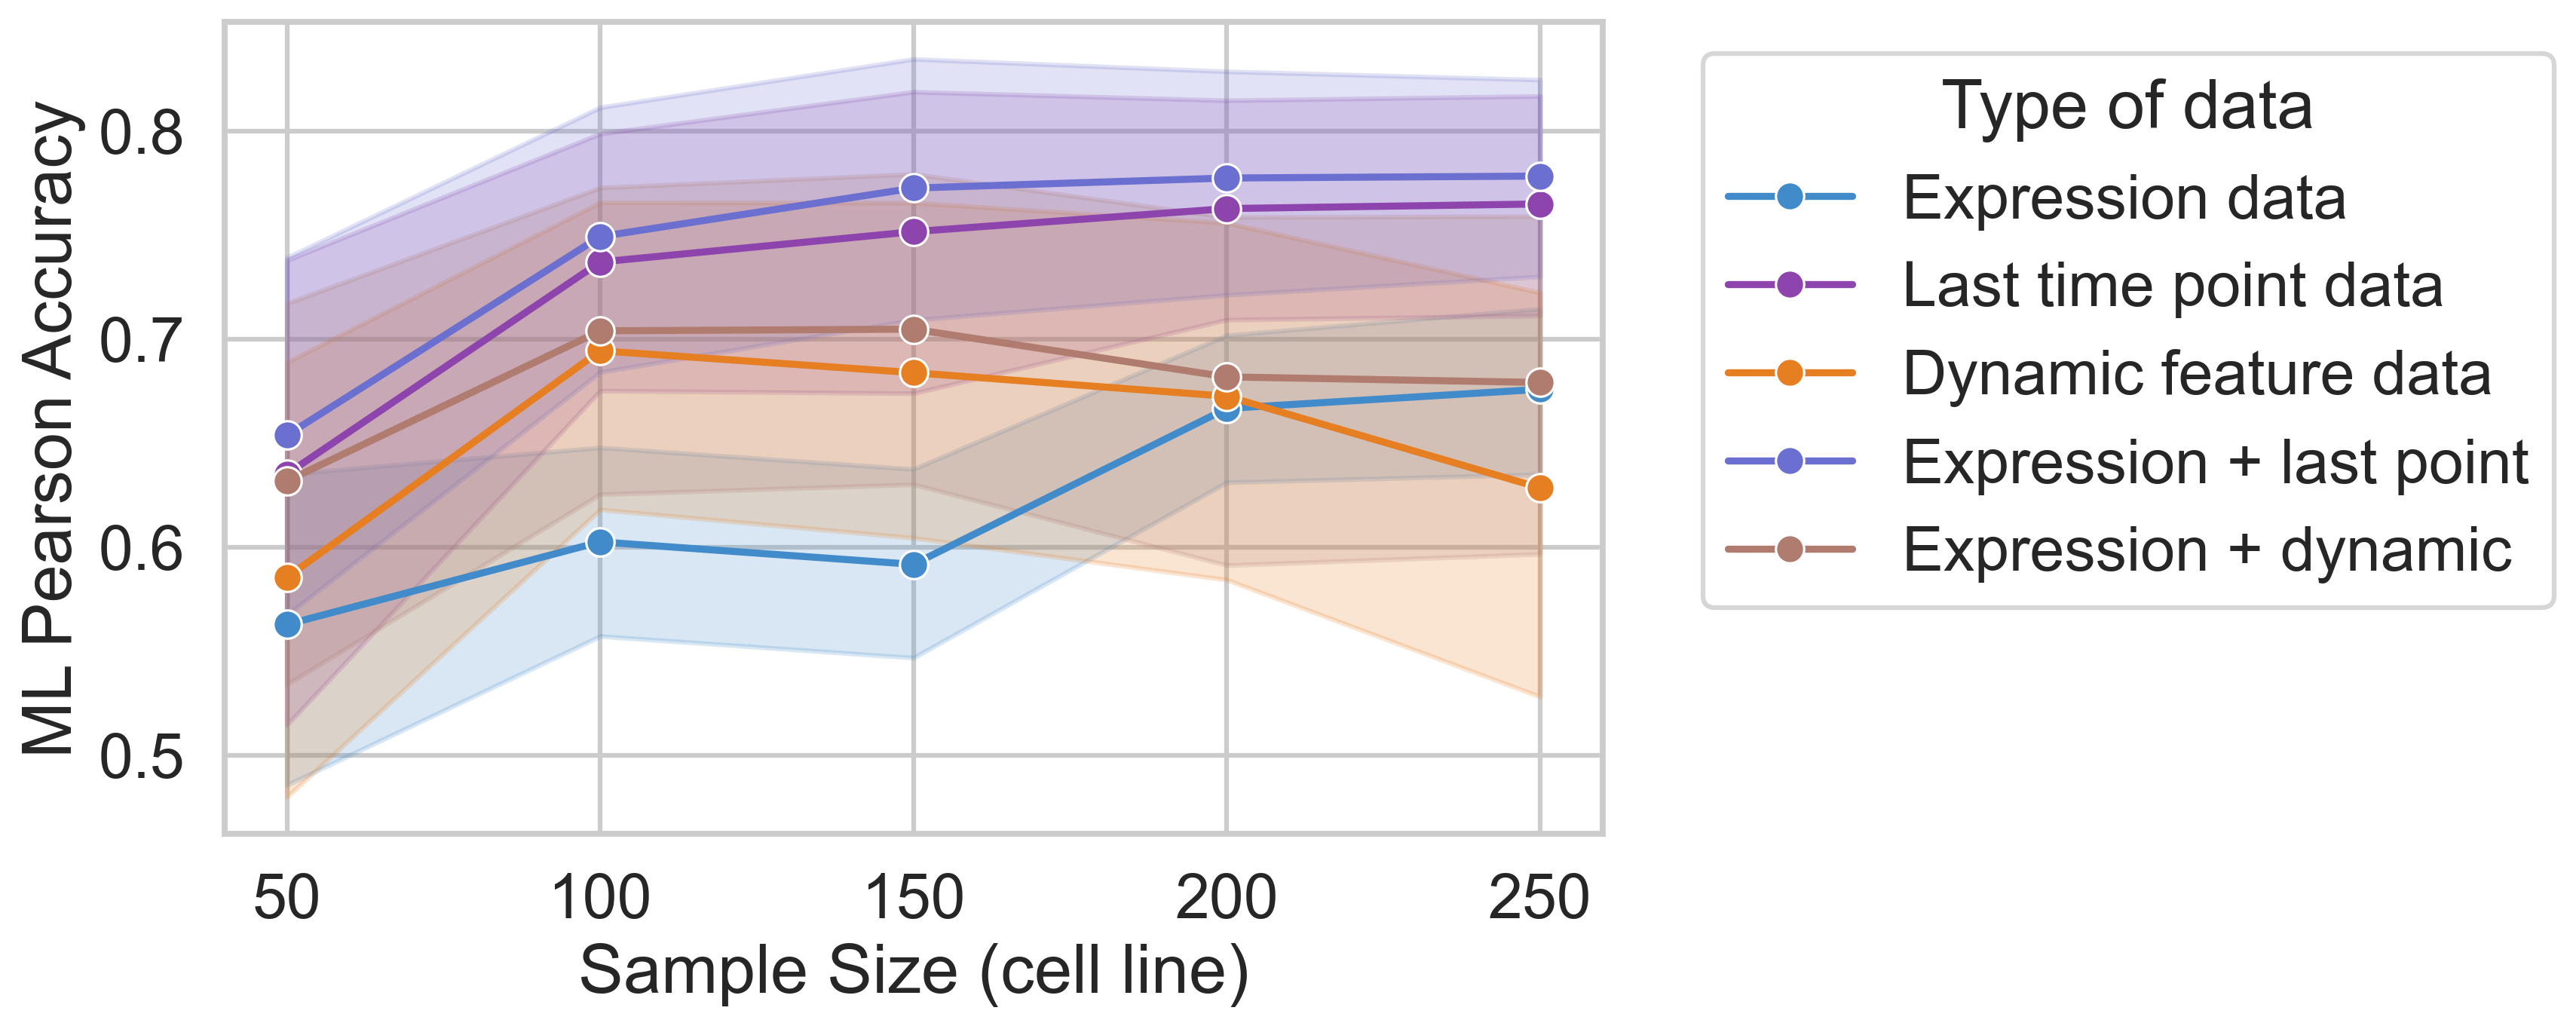

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess data
plot_data = results_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})


# Define the custom color palette
color_map = {
    'Expression data': '#428bca',
    'Last time point data': '#8e44ad',
    'Dynamic feature data': '#e67e22',
    'Expression + last point': '#6b6fcf',
    'Expression + dynamic': '#b07c6f'
}

# Set up plot appearance
plt.figure(figsize=(12, 5), dpi=300)
sns.set_style("whitegrid", {"font": "Arial"})
sns.set_context("talk", font_scale=1.2)

# Plot the line chart using the color map
sns.lineplot(
    data=plot_data,
    x='sample_size',
    y='Pearson Correlation',
    hue='Feature Data',
    palette=color_map,
    marker='o'
)

# Rotate x-axis labels
plt.xticks(rotation=0)

plt.ylabel('ML Pearson Accuracy')
plt.xlabel('Sample Size (cell line)')


# Legend to the right
plt.legend(title='Type of data', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
